# First model for Deconvolution
Author: Raphael Pereira Rolim e Silva

> Here I try to construct a initial model to deconvolve HI maps.

## Dependecies and functions

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input
#############################################
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
import sys, os
import glob
from natsort import natsorted
##############################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import handling_data as hdata
import beam_modelling as model

In [2]:
def array_to_healpix(projection, dec_range, ra_range, nside):
    """
    Convert a 3D array projection into a multi-band HEALPix map.

    Parameters:
    - projection: array-like 
        3D array of shape (num_bands, height, width).
    - dec_range: array-like
        Range of declination in degrees where dec_range[0] is the minimum and dec_range[1] is the maximum.
    - ra_range: array-like
        Range of right ascension in degrees where ra_range[0] is the minimum and ra_range[1] is the maximum.
    - nside: int
        HEALPix nside parameter.

    Returns:
    healpix_map: HEALPix map
        HEALPix map array of shape (num_bands, 12 * nside**2).
    """
    num_bands, height, width = projection.shape
    
    # Initialize HEALPix map array
    if num_bands > 1:
        healpix_map = np.full((num_bands, 12 * nside**2), hp.UNSEEN)
    else:
        healpix_map = np.full(12 * nside**2, hp.UNSEEN)

    # Convert RA and Dec to theta (colatitude) and phi (longitude) in radians
    theta_range = np.radians([90.0 - dec_range[1], 90.0 - dec_range[0]])  # theta_min, theta_max
    phi_range = np.radians(ra_range)  # phi_min, phi_max

    # Set up the Mollweide projection grid
    theta = np.linspace(theta_range[0], theta_range[1], height)  # Latitude from dec_min to dec_max
    phi = np.linspace(phi_range[0], phi_range[1], width)  # Longitude from ra_min to ra_max
    phi, theta = np.meshgrid(phi, theta)  # Create a mesh grid for theta and phi

    # Convert theta, phi to HEALPix pixel indices
    pix_indices = hp.ang2pix(nside, theta.flatten(), phi.flatten())

    if num_bands > 1:
        # Map values to HEALPix pixels for each band
        for band in range(num_bands):
            healpix_map[band, pix_indices] = projection[band].flatten()
    else:
        healpix_map[pix_indices] = projection.flatten()

    return healpix_map

## Model 0

### The Work

In [3]:
# Get tensors
clean_projections = [np.transpose(np.load(f'./preliminary_dataset/og_maps/og_map_{i}.npy')) for i in range(30)]
clean_tensor = tf.convert_to_tensor(clean_projections, dtype=tf.float32)

smooth_projections = [np.transpose(np.load(f'./preliminary_dataset/g_smoothed_maps/g_smoothed_map_{i}.npy')) for i in range(30)]
smooth_tensor = tf.convert_to_tensor(smooth_projections, dtype=tf.float32)

2024-07-02 16:46:24.225657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


> Need to transpose them because NN are expecting the shape (width, height, color_channel).

In [4]:
# Spliting dataset into training and testing
clean_train = clean_tensor[0:26]
clean_test  = clean_tensor[26:30]

smooth_train = smooth_tensor[0:26]
smooth_test = smooth_tensor[26:30] 

# Check shape
(clean_train.shape, smooth_train.shape), (clean_test.shape, smooth_test.shape)

((TensorShape([26, 256, 256, 1]), TensorShape([26, 256, 256, 1])),
 (TensorShape([4, 256, 256, 1]), TensorShape([4, 256, 256, 1])))

In [5]:
# Let's define the Peak to Signal Ratio metric
def psnr_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

In [6]:
# Create model
input_shape = (256, 256, 1)

model0 = tf.keras.Sequential([
    Input(shape=input_shape, name='Input'),
    
    # Encoder
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2D_1'),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2D_2'),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2D_3'),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2D_4'),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2D_5'),

    # Output layer
    Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Output')
])

In [7]:
# Compile model
model0.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', psnr_metric]
)

# Summary
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 256, 256, 64)      640       
                                                                 
 Conv2D_2 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Conv2D_3 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Conv2D_4 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Conv2D_5 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Output (Conv2D)             (None, 256, 256, 1)       577       
                                                                 
Total params: 148929 (581.75 KB)
Trainable params: 14892

In [8]:
# Fit model
model0_history = model0.fit(smooth_train, clean_train, epochs=12, validation_data=(smooth_test, clean_test))

Epoch 1/12
1/1 [==============================] - 11s 11s/step - loss: 0.2227 - accuracy: 0.0000e+00 - psnr_metric: 6.5256 - val_loss: 0.1628 - val_accuracy: 0.0000e+00 - val_psnr_metric: 7.8914
Epoch 2/12
1/1 [==============================] - 8s 8s/step - loss: 0.1901 - accuracy: 0.0000e+00 - psnr_metric: 7.2194 - val_loss: 0.1276 - val_accuracy: 0.0000e+00 - val_psnr_metric: 8.9614
Epoch 3/12
1/1 [==============================] - 8s 8s/step - loss: 0.1640 - accuracy: 0.0000e+00 - psnr_metric: 7.8728 - val_loss: 0.0860 - val_accuracy: 0.0000e+00 - val_psnr_metric: 10.6966
Epoch 4/12
1/1 [==============================] - 8s 8s/step - loss: 0.1299 - accuracy: 0.0000e+00 - psnr_metric: 8.9134 - val_loss: 0.0491 - val_accuracy: 0.0000e+00 - val_psnr_metric: 13.1423
Epoch 5/12
1/1 [==============================] - 8s 8s/step - loss: 0.0922 - accuracy: 0.0000e+00 - psnr_metric: 10.4551 - val_loss: 0.0266 - val_accuracy: 0.0000e+00 - val_psnr_metric: 15.7827
Epoch 6/12
1/1 [=============

### Plot and conclusions

In [9]:
# Model Summary again
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 256, 256, 64)      640       
                                                                 
 Conv2D_2 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Conv2D_3 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Conv2D_4 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Conv2D_5 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 Output (Conv2D)             (None, 256, 256, 1)       577       
                                                                 
Total params: 148929 (581.75 KB)
Trainable params: 14892

Model 0 is constructed with 5 `Conv2D` layers, with 64 filters each and one final `Conv2D` Output layer with 1 filter (gray scale).

In [30]:
# Create dataframe
model0_dataframe = pd.DataFrame(model0_history.history)

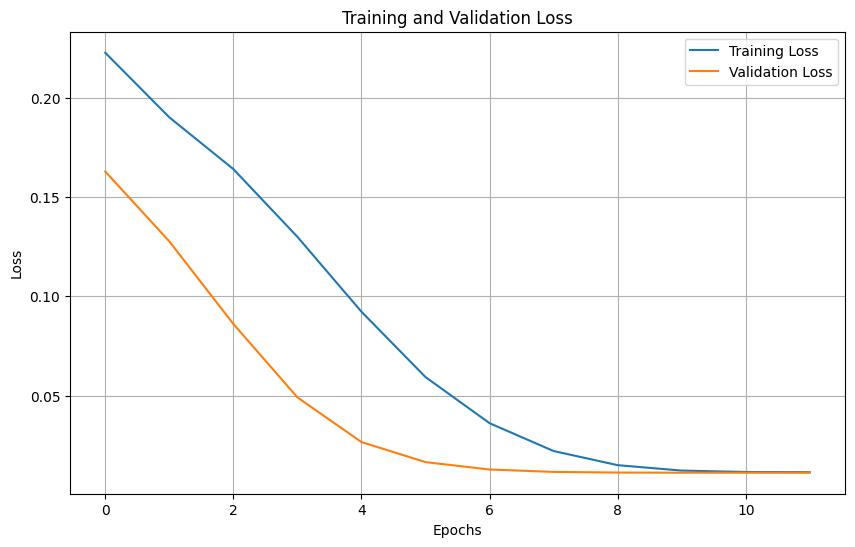

In [23]:
epochs = range(len(model0_dataframe))

plt.figure(figsize=(10, 6))
plt.plot(epochs, model0_dataframe['loss'], label='Training Loss')
plt.plot(epochs, model0_dataframe['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

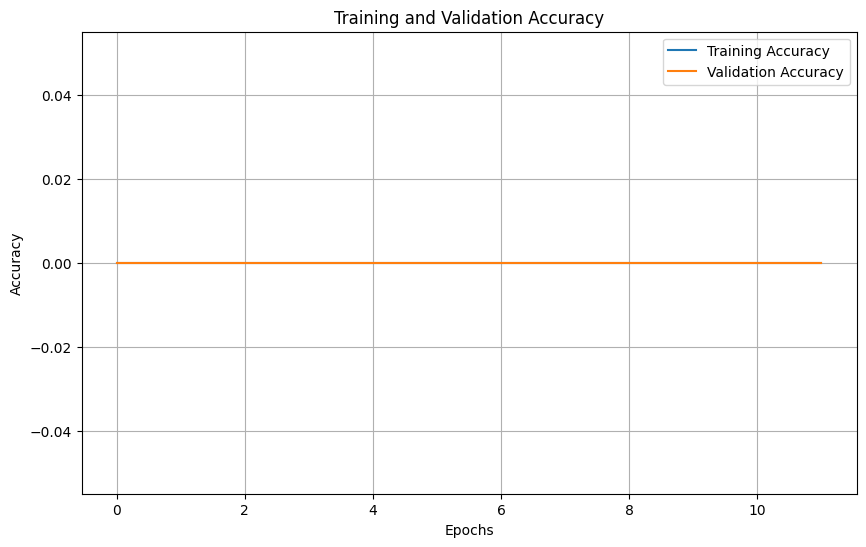

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, model0_dataframe['accuracy'], label='Training Accuracy')
plt.plot(epochs, model0_dataframe['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

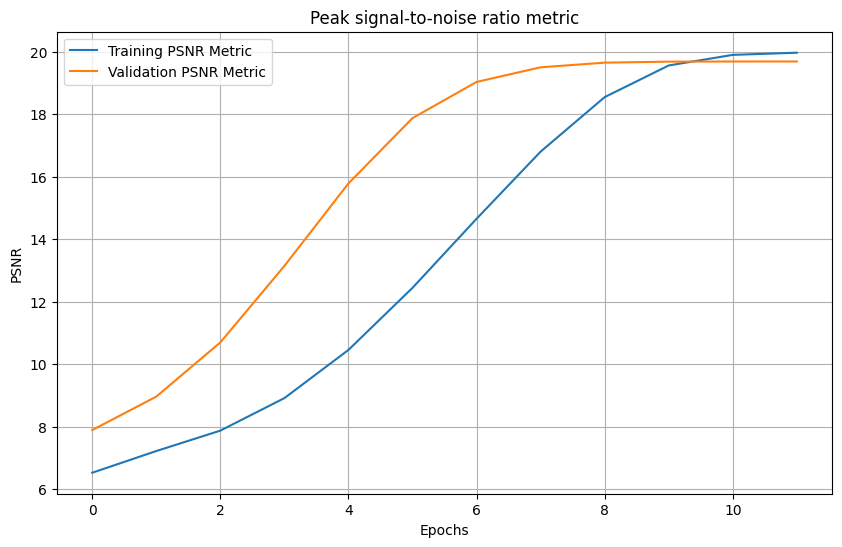

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, model0_dataframe['psnr_metric'], label='Training PSNR Metric')
plt.plot(epochs, model0_dataframe['val_psnr_metric'], label='Validation PSNR Metric')
plt.title('Peak signal-to-noise ratio metric')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Model prediction
yhat = np.squeeze(model0.predict(smooth_test[0]), axis=2)
yhat.shape

8/8 [==============================] - 0s 8ms/step


(256, 256, 1)

In [11]:
# Transpose again to plot
yhat_img = np.transpose(yhat)
clean_img = np.transpose(clean_test[0])
smooth_img = np.transpose(smooth_test[0])

In [12]:
# Transform into HEALPix map
dec = [-4, 4]
ra = [-4, 4]

pred = array_to_healpix(yhat_img, dec, ra, nside=512)
clean = array_to_healpix(clean_img, dec, ra, nside=512)
smooth = array_to_healpix(smooth_img, dec, ra, nside=512)

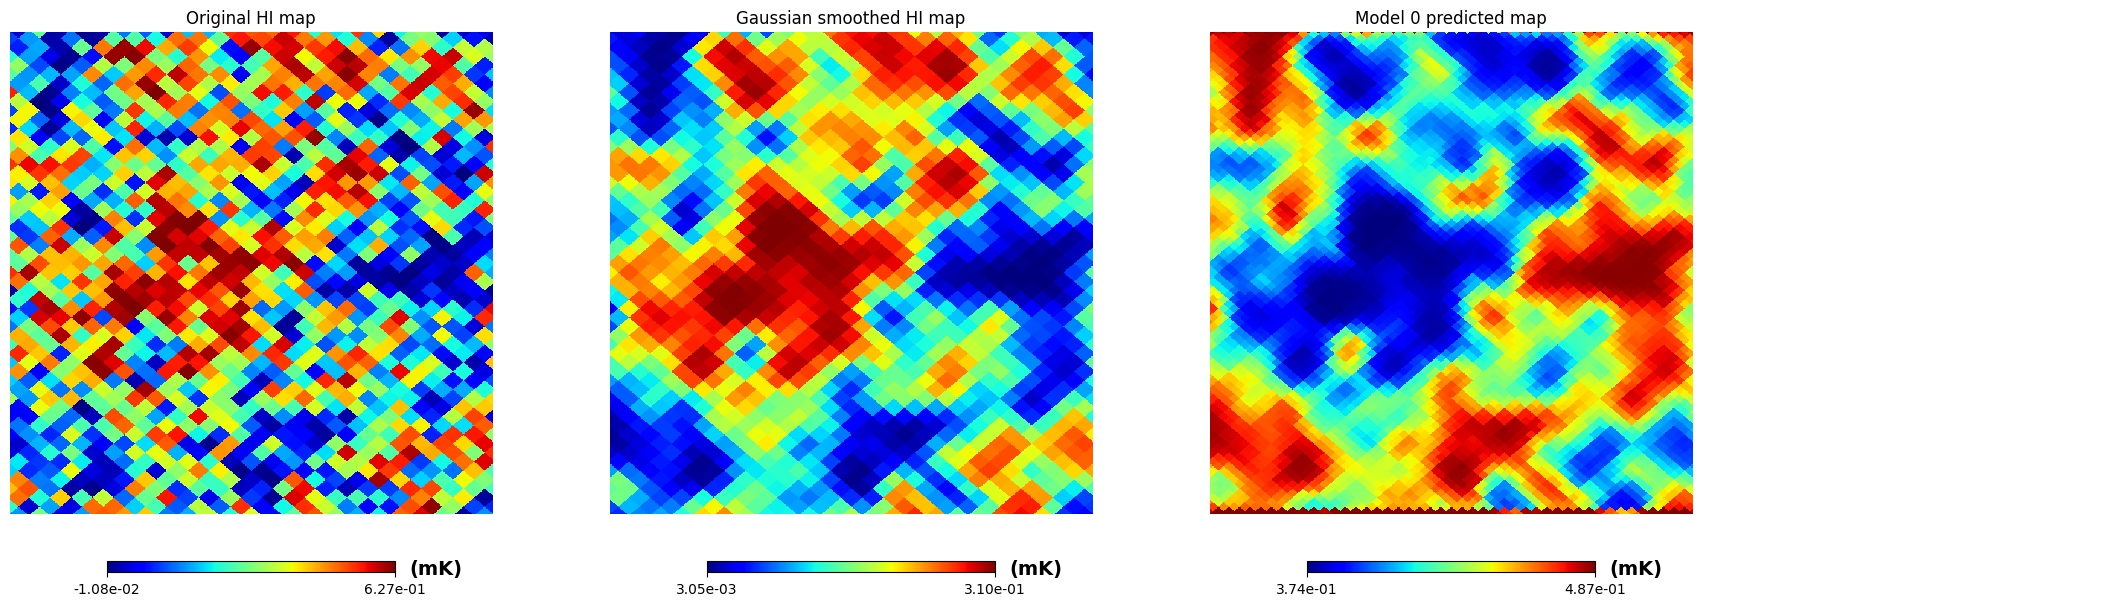

In [13]:
# Plot and compare
fig, axes = plt.subplots(1, 3, figsize=(24, 6),
                         subplot_kw={'projection': None},
                         gridspec_kw={'wspace': 0.1})

smoothed_titles = [
    'Original HI map',
    'Gaussian smoothed HI map',
    'Model 0 predicted map'
]

maps = [clean, smooth, pred]

# Plot each map individually
hp.cartview(maps[0], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[0], fig=fig, sub=(1, 4, 1))
hp.cartview(maps[1], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[1], fig=fig, sub=(1, 4, 2))
hp.cartview(maps[2], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[2], fig=fig, sub=(1, 4, 3))

# Hide the axes for all subplots to remove traces
for ax in axes:
    ax.set_axis_off()

#plt.savefig('limited_cartview_maps.png', bbox_inches='tight')

plt.show()

#### What happened?

The dataset used here is composed of 60 images, where 30 are the original maps (not convolved) and 30 are convolved maps by a gaussian function. To create the training data and test data, I didn't randomize the order of the maps or augmented the data. They were used the way they were originally made.

By the result image above, we can clearly see that everything the Neural Network (NN) did was turn bright pixels into cold ones and the predicted map is even more smoothed than the original one!

We can also see a litte amount of red pixels at the bottom of the image.